In [1]:
import pandas as pd 
import numpy as np 
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
centers = [[1, 1], [1, -2]]
X, labels_true = make_blobs(
    n_samples=750, 
    centers=centers, 
    cluster_std=0.4,
    random_state=0
)

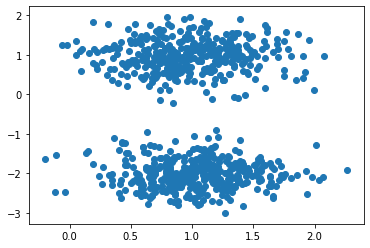

In [3]:
plt.scatter(X[:,0], X[:,1])

## Logistic Regression

For optimizing, the following form for the first derivative is being used ([source](https://www.youtube.com/watch?v=KIhPtHOfbhQ&t=533s)]: 

$$\frac{1}{N}\sum_{i = 1}^{N}{x_i \cdot (1 - \frac{e^{-\omega^{T}x_i}}{1 + e^{-\omega^{T}x_i}}) - y_i}$$

which is equivalent to: 

$$\frac{1}{N}\sum_{i = 1}^{N}{x_i \cdot p(y_i = 1 | x_i; \omega) - y_i}$$

In [4]:
class LogisticRegression(): 
    def __init__(
        self, 
        alpha = 0.01, 
        add_bias=True,
        verbose=True, 
        n_iterations = 1000
    ): 
        self.alpha = alpha
        self.add_bias = add_bias
        self.verbose = verbose
        self.n_iterations = n_iterations
        
        # Internals 
        self._fitted = False
    
    
    def fit(self, X, y):
        X, self.omega = self._parametrize_transform(X)
        i = 0
        try: 
            while True:
                i += 1
                # Gradient Descent
                gradient = self._calc_gradient(X, y, self.omega)
                self.omega  = self.omega - self.alpha * gradient
                
                # Stats
                self._skip_scaling = True
                predictions = self.predict(X)
                self._skip_scaling = False
                
                acc = accuracy_score(predictions, y)
                
                if i % 100 == True: 
                    if self.verbose == True: 
                        print("Accuracy for iteration {}: {}".format(i, acc))
                if i >= self.n_iterations: 
                    break
                 
        except KeyboardInterrupt: 
            self._fitted = True
            return self

        self._fitted = True
        return self
    
    def predict_proba(self, X): 
        if self._skip_scaling == False: 
            if not self._fitted: 
                raise Exception("Must fit first!")
            X, _ = self._parametrize_transform(X) 
            return np.asarray([self.sigmoid(self.omega, x) for x in X])
        else:
            return np.asarray([self.sigmoid(self.omega, x) for x in X])
    
    def predict(self, X): 
        ######################
        # Super weird bug !! #
        ######################
        # The predictions seem to be inverted perfectly, 
        # all 0 are predicted as 1 and vice versa! 
        # The following should be correct:
        #return (self.predict_proba(X) >= 0.5).astype(int)
        # Instead this works: 
        return (self.predict_proba(X) < 0.5).astype(int)
    
    ######################
    # Internal Functions #
    ######################
    
    def sigmoid(self, omega, x): 
        return 1/(1 + np.exp(-omega.T @ x))
    
    def _parametrize_transform(self, X):
        assert X.ndim == 2
        if self.add_bias: 
            X = np.c_[np.ones(X.shape[0]), X]
        omega = np.zeros(X.shape[1])
        return X, omega 
    
    def _p_positive(self, x, omega): 
        numerator = np.exp(-omega.T @ x)
        denominator = 1 + numerator 
        return 1 - (numerator/denominator)
    
    def _calc_gradient(self, X, y, omega):
        for i, x_y_ in enumerate(zip(X, y)):
            x, y_ = x_y_
            curr_gradient = (x * self._p_positive(x, omega)) - y_
            if i == 0: 
                result = curr_gradient
            else: 
                result = np.vstack((result, curr_gradient))
        
        gradient = np.sum(np.asarray(result), axis=0) / len(X)
        assert gradient.shape == (X.shape[1],)
        return gradient


## Fit, Predict and Evaluate 

In [5]:
log_reg = LogisticRegression(alpha=0.1, n_iterations=100)
log_reg.fit(X, labels_true)

Accuracy for iteration 1: 0.992


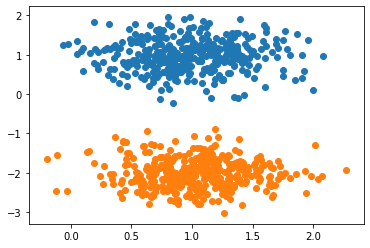

In [6]:
preds = log_reg.predict(X)
for i in set(preds): 
    curr_X = X[preds == i]
    plt.scatter(curr_X[:,0], curr_X[:,1])